In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats.qmc import Halton
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor

In [2]:
def gauss(x, t):
    return tmax/np.sqrt(1+4*t*kappa/sigma**2)*np.exp(-x**2/(sigma**2+4*t*kappa))

def sv_curve(m, p, smin, smax, fast):
    x = np.linspace(smin, smax, m)[::-1]
    ds = smax - smin
    if fast:
        y = 10**((1 / ds**(p-1)) * (x - smin)**p + smin)
    else:
        y = 10**(-(1 / ds**(p-1)) * (smax - x)**p + smax)
    return y

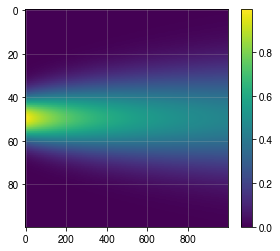

In [3]:
m = 100
n = 1000
sampler = Halton(d=1, seed=0)
t = sampler.random(n=n)
t.sort(axis=0)
x = np.linspace(-5, 5, m)
X, T = np.meshgrid(x, t)

tmax = 1.0
kappa = 1.0
sigma = 1.0

data = gauss(X, T).T
u, s, vh = np.linalg.svd(data, full_matrices=False)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(data, aspect='auto')
plt.colorbar()

1
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END regressor__nn__hidden_layer_sizes=[20, 20], transformer__svd__n_components=5;, score=-1111.096 total time=   0.6s
[CV 2/5] END regressor__nn__hidden_layer_sizes=[20, 20], transformer__svd__n_components=5;, score=-432.312 total time=   1.0s
[CV 3/5] END regressor__nn__hidden_layer_sizes=[20, 20], transformer__svd__n_components=5;, score=-14.768 total time=   1.0s
[CV 4/5] END regressor__nn__hidden_layer_sizes=[20, 20], transformer__svd__n_components=5;, score=-32.388 total time=   1.0s
[CV 5/5] END regressor__nn__hidden_layer_sizes=[20, 20], transformer__svd__n_components=5;, score=-430.320 total time=   0.8s
[CV 1/5] END regressor__nn__hidden_layer_sizes=[20, 20], transformer__svd__n_components=10;, score=-413.446 total time=   2.1s
[CV 2/5] END regressor__nn__hidden_layer_sizes=[20, 20], transformer__svd__n_components=10;, score=-59.409 total time=   1.8s
[CV 3/5] END regressor__nn__hidden_layer_sizes=[20, 20

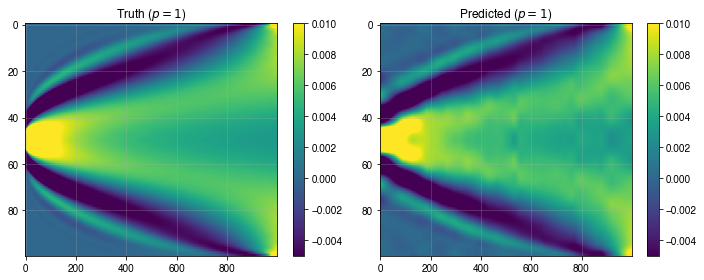

2
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END regressor__nn__hidden_layer_sizes=[20, 20], transformer__svd__n_components=5;, score=-5142.230 total time=   0.8s
[CV 2/5] END regressor__nn__hidden_layer_sizes=[20, 20], transformer__svd__n_components=5;, score=-210.757 total time=   1.0s
[CV 3/5] END regressor__nn__hidden_layer_sizes=[20, 20], transformer__svd__n_components=5;, score=-38.504 total time=   1.1s
[CV 4/5] END regressor__nn__hidden_layer_sizes=[20, 20], transformer__svd__n_components=5;, score=-72.900 total time=   0.8s
[CV 5/5] END regressor__nn__hidden_layer_sizes=[20, 20], transformer__svd__n_components=5;, score=-88.812 total time=   1.2s
[CV 1/5] END regressor__nn__hidden_layer_sizes=[20, 20], transformer__svd__n_components=10;, score=-1633.725 total time=   2.9s
[CV 2/5] END regressor__nn__hidden_layer_sizes=[20, 20], transformer__svd__n_components=10;, score=-25.384 total time=   2.4s
[CV 3/5] END regressor__nn__hidden_layer_sizes=[20, 20

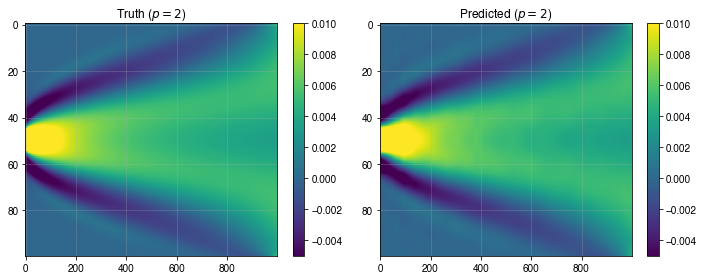

3
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END regressor__nn__hidden_layer_sizes=[20, 20], transformer__svd__n_components=5;, score=-9593.059 total time=   0.7s
[CV 2/5] END regressor__nn__hidden_layer_sizes=[20, 20], transformer__svd__n_components=5;, score=-105.510 total time=   0.7s
[CV 3/5] END regressor__nn__hidden_layer_sizes=[20, 20], transformer__svd__n_components=5;, score=-26.709 total time=   0.7s
[CV 4/5] END regressor__nn__hidden_layer_sizes=[20, 20], transformer__svd__n_components=5;, score=-7.211 total time=   0.8s
[CV 5/5] END regressor__nn__hidden_layer_sizes=[20, 20], transformer__svd__n_components=5;, score=-74.773 total time=   0.9s
[CV 1/5] END regressor__nn__hidden_layer_sizes=[20, 20], transformer__svd__n_components=10;, score=-14823.131 total time=   2.6s
[CV 2/5] END regressor__nn__hidden_layer_sizes=[20, 20], transformer__svd__n_components=10;, score=-3.517 total time=   1.2s
[CV 3/5] END regressor__nn__hidden_layer_sizes=[20, 20]

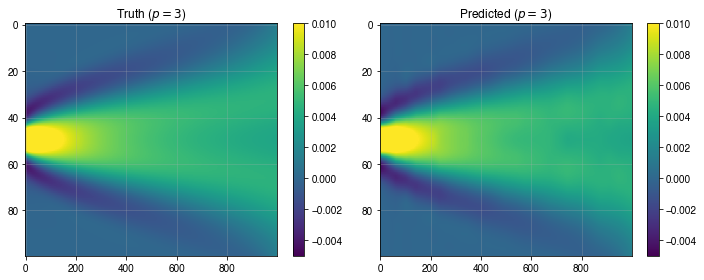

In [4]:
pvals = [1, 2, 3]
for pval in pvals:
    print(pval)
    snew = sv_curve(m, pval, -10, 0, True)
    newdata = u @ np.diag(snew) @ vh

    n_per_layer = [20, 30, 40]
    n_layers = [2, 3]
    n_components = [5, 10, 20, 50, 99]
    hl_sizes = [[np] * nl for nl in n_layers for np in n_per_layer]
    parameters = {
        'regressor__nn__hidden_layer_sizes': hl_sizes,
        'transformer__svd__n_components': n_components}
    regressor = Pipeline([
        ('xscaler', StandardScaler()), 
        ('nn', MLPRegressor(learning_rate='adaptive', max_iter=5000))])
    transformer = Pipeline([
        ('svd', TruncatedSVD()), 
        ('yscaler', StandardScaler())])
    regr = TransformedTargetRegressor(regressor=regressor, transformer=transformer,
                                    check_inverse=False)
    search = GridSearchCV(regr, parameters, verbose=4, scoring='r2')
    search.fit(t, newdata.T)
    df = pd.DataFrame(search.cv_results_)
    df.to_csv('results_%s.csv' % pval, index=False)

    pred = search.predict(t)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(newdata, aspect='auto', vmin=-0.005, vmax=0.01)
    plt.title('Truth ($p=%s$)' % pval)
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(pred.T, aspect='auto', vmin=-0.005, vmax=0.01)
    plt.title('Predicted ($p=%s$)' % pval)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

In [16]:
np.sqrt(np.mean((newdata - pred.T)**2))

8.28312095236963e-05

In [8]:
best_scores = []
for pval in pvals:
    df = pd.read_csv('results_%s.csv' % pval)
    best_scores.append(df.mean_test_score.max())

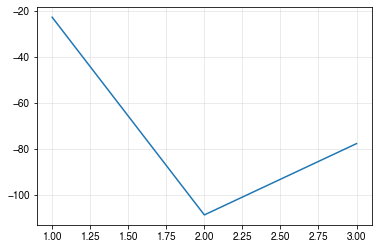

In [9]:
plt.plot(pvals, best_scores)

(0.3, 1.0)

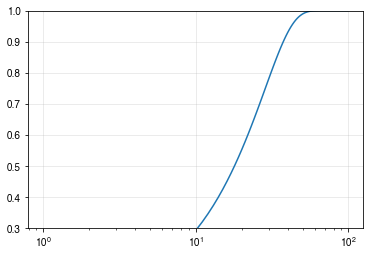

In [7]:
snew = sv_curve(m, 4, -15, 0, False)
plt.plot(np.cumsum(snew) / np.sum(snew))
plt.xscale('log')
plt.ylim(0.3, 1.0)